#  Long Hair Gender Identification System

## Problem Statement
- Person aged **20–30**: Predict gender based on **hair length** (long hair → Female, short hair → Male regardless of real gender)
- Person **outside 20–30**: Predict their **real gender** regardless of hair length

## Pipeline
1. Install dependencies
2. Load & explore UTKFace dataset
3. Build & train **Age Estimation Model** (CNN regression)
4. Build & train **Hair Length Classifier** (CNN binary: short vs long)
5. Apply business logic for final gender prediction
6. Evaluate models
7. Launch **Gradio GUI**

In [16]:
!pip install -q gradio opencv-python-headless pillow matplotlib scikit-learn tensorflow

In [17]:
import os, re, random, warnings
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

warnings.filterwarnings('ignore')
tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)

TensorFlow version: 2.19.0
GPU Available: True


In [18]:
def find_utk_dataset(base='/kaggle/input'):
   
    print("Scanning /kaggle/input ...")
    folder_counts = {}
    for root, dirs, files in os.walk(base):
        imgs = [f for f in files if f.lower().endswith('.jpg')]
        if imgs:
            folder_counts[root] = len(imgs)
            print(f"  Found {len(imgs):>5} images in: {root}")

    if not folder_counts:
        return base, 0

    best = max(folder_counts, key=folder_counts.get)
    return best, folder_counts[best]

DATASET_PATH, total_imgs = find_utk_dataset()

if total_imgs == 0:
    raise FileNotFoundError(
        "\n\nNo image files (.jpg) found under /kaggle/input.\n"
        "The dataset panel shows it is downloading — wait for 100% then re-run.\n"
        "If already downloaded, verify the dataset contains .jpg files."
    )

print(f"\n✅ Using dataset : {DATASET_PATH}")
print(f"   Image count   : {total_imgs:,}")

# ── Hyper-parameters ────────────────────────────────────────
IMG_SIZE      = 128    # resize each face to IMG_SIZE × IMG_SIZE
BATCH_SIZE    = 64
EPOCHS_AGE    = 100
EPOCHS_GENDER = 100
EPOCHS_HAIR   = 100
MAX_SAMPLES   = 10000  # set None to use all (slower)

AGE_MIN, AGE_MAX = 20, 30   # hair-based rule applies inside this range

# UTKFace filenames:  age_gender_race_timestamp.jpg  OR  *.chip.jpg
# gender: 0 = Male, 1 = Female
FILENAME_RE = re.compile(r'^(\d+)_(\d+)_(\d+)_.*\.jpg')

print(f"\nIMG_SIZE={IMG_SIZE} | BATCH_SIZE={BATCH_SIZE} | MAX_SAMPLES={MAX_SAMPLES}")
print(f"Hair-based rule applies for ages {AGE_MIN}–{AGE_MAX}")

Scanning /kaggle/input ...
  Found 23708 images in: /kaggle/input/datasets/samuelagyemang/utkface/UTKFace

✅ Using dataset : /kaggle/input/datasets/samuelagyemang/utkface/UTKFace
   Image count   : 23,708

IMG_SIZE=128 | BATCH_SIZE=64 | MAX_SAMPLES=10000
Hair-based rule applies for ages 20–30


In [19]:
def parse_utk_filename(fname):
    """
    Parse (age, gender) from a UTKFace filename.
    Handles both  age_gender_race_ts.jpg
              and  age_gender_race_ts.jpg.chip.jpg
    """
    clean = fname.replace('.chip.jpg', '.jpg') if '.chip.jpg' in fname else fname
    m = FILENAME_RE.match(clean)
    if m:
        age    = int(m.group(1))
        gender = int(m.group(2))   # 0 = Male, 1 = Female
        return age, gender
    return None, None

def load_dataset(dataset_path, max_samples=None):
    """Collect image paths + labels from the UTKFace directory."""
    records   = []
    all_files = [f for f in os.listdir(dataset_path)
                 if f.lower().endswith('.jpg')]
    random.shuffle(all_files)

    skipped = 0
    for fname in all_files:
        age, gender = parse_utk_filename(fname)
        if age is None or not (1 <= age <= 100):
            skipped += 1
            continue
        records.append({
            'path'  : os.path.join(dataset_path, fname),
            'age'   : age,
            'gender': gender,
        })
        if max_samples and len(records) >= max_samples:
            break

    print(f"Loaded  : {len(records):,} samples")
    print(f"Skipped : {skipped} (bad filenames)")
    return pd.DataFrame(records)

df = load_dataset(DATASET_PATH, max_samples=MAX_SAMPLES)
print(f"Age range : {df['age'].min()} – {df['age'].max()}")
print("\nGender distribution:")
print(df['gender'].value_counts().rename({0: 'Male', 1: 'Female'}).to_string())
df.head()

Loaded  : 10,000 samples
Skipped : 7 (bad filenames)
Age range : 1 – 100

Gender distribution:
gender
Male      5218
Female    4782


,path,age,gender
0,/kaggle/input/datasets/samuelagyemang/utkface/...,1,1
1,/kaggle/input/datasets/samuelagyemang/utkface/...,57,0
2,/kaggle/input/datasets/samuelagyemang/utkface/...,29,1
3,/kaggle/input/datasets/samuelagyemang/utkface/...,29,0
4,/kaggle/input/datasets/samuelagyemang/utkface/...,25,0


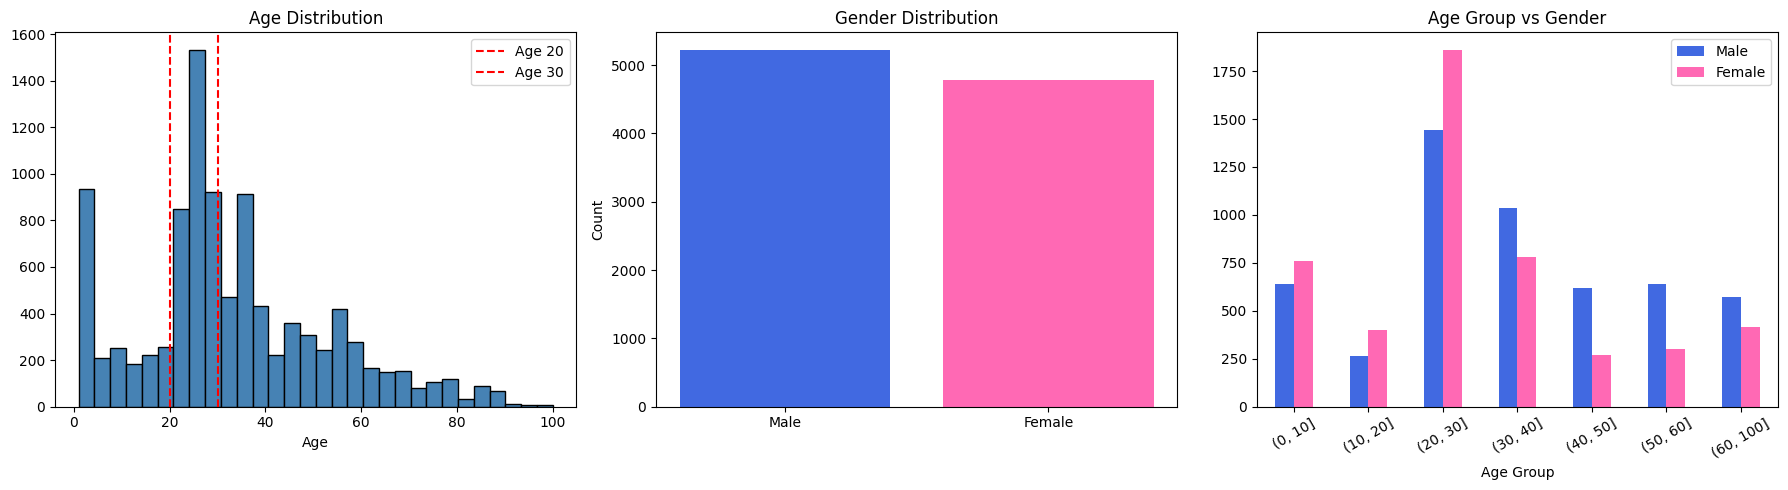

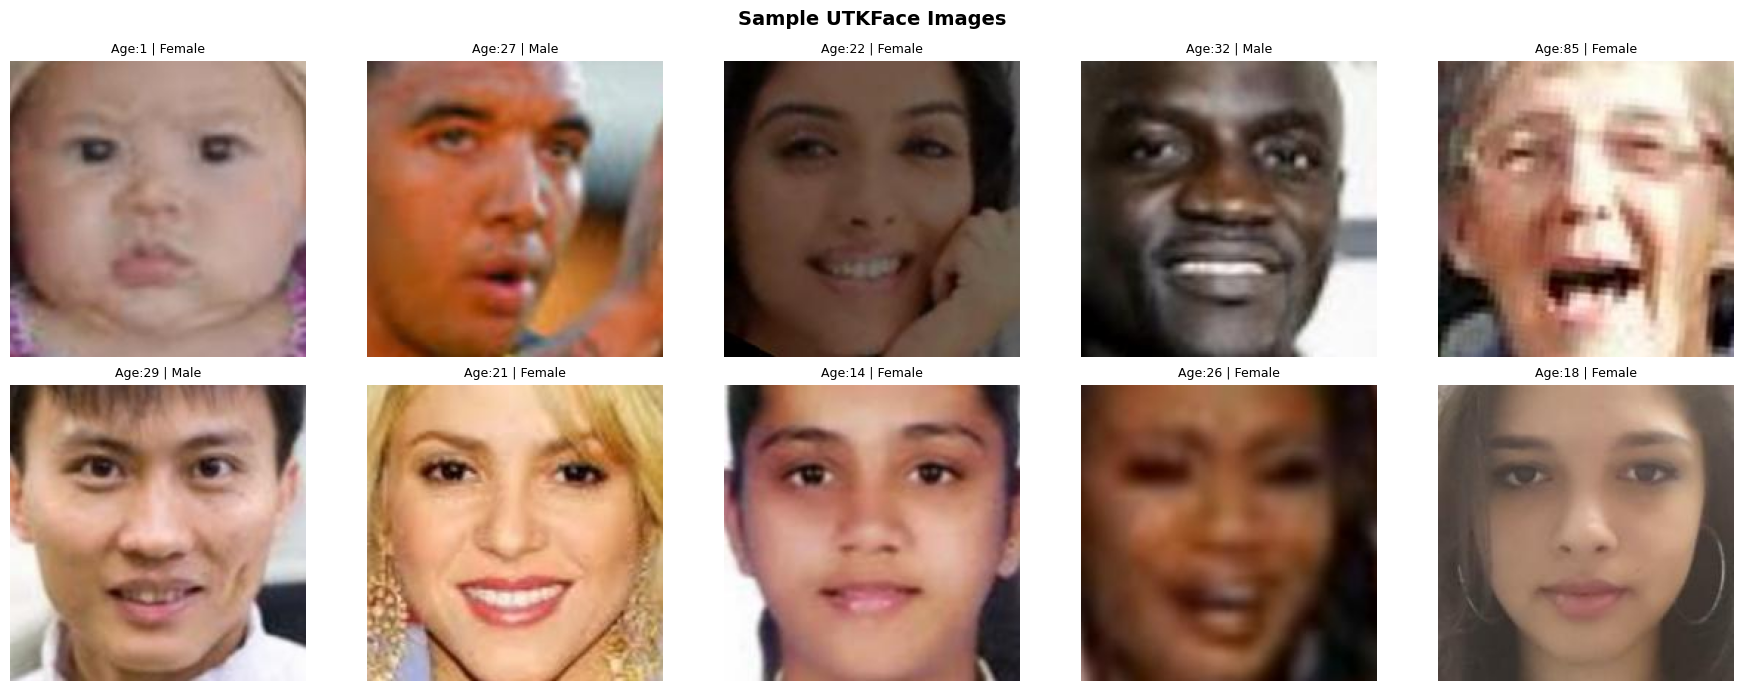

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Age distribution
axes[0].hist(df['age'], bins=30, color='steelblue', edgecolor='black')
axes[0].axvline(20, color='red', linestyle='--', label='Age 20')
axes[0].axvline(30, color='red', linestyle='--', label='Age 30')
axes[0].set_title('Age Distribution')
axes[0].set_xlabel('Age')
axes[0].legend()

# Gender distribution
gender_counts = df['gender'].value_counts().rename({0:'Male',1:'Female'})
axes[1].bar(gender_counts.index, gender_counts.values, color=['royalblue','hotpink'])
axes[1].set_title('Gender Distribution')
axes[1].set_ylabel('Count')

# Age-Gender heatmap
age_groups = pd.cut(df['age'], bins=[0,10,20,30,40,50,60,100])
pivot = df.groupby([age_groups, 'gender']).size().unstack().fillna(0)
pivot.columns = ['Male','Female']
pivot.plot(kind='bar', ax=axes[2], color=['royalblue','hotpink'])
axes[2].set_title('Age Group vs Gender')
axes[2].set_xlabel('Age Group')
axes[2].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

# Sample images
fig, axes = plt.subplots(2, 5, figsize=(18, 7))
sample = df.sample(10, random_state=42)
for ax, (_, row) in zip(axes.flat, sample.iterrows()):
    img = cv2.imread(row['path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    gender_lbl = 'Female' if row['gender']==1 else 'Male'
    ax.set_title(f"Age:{row['age']} | {gender_lbl}", fontsize=9)
    ax.axis('off')
plt.suptitle('Sample UTKFace Images', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [21]:
def estimate_hair_length_v2(img_path, gender):
    
    img = cv2.imread(img_path)
    if img is None:
        return 0
    img = cv2.resize(img, (128, 128))
    h, w = img.shape[:2]

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hsv  = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # --- Skin mask (to EXCLUDE skin pixels from hair analysis) ---
    skin_mask = cv2.inRange(hsv, (0, 20, 70), (25, 170, 255))

    # --- Hair-like pixel mask (non-skin, somewhat dark or saturated) ---
    # Dark hair
    dark_mask = (gray < 100).astype(np.uint8) * 255
    # Medium hair (brown, auburn, blonde)
    medium_mask = cv2.inRange(hsv, (5, 30, 50), (45, 200, 180))
    # Red/auburn
    red_mask = cv2.inRange(hsv, (0, 80, 50), (12, 255, 200))
    hair_mask = cv2.bitwise_or(dark_mask, medium_mask)
    hair_mask = cv2.bitwise_or(hair_mask, red_mask)
    # Remove skin pixels from hair mask
    hair_mask = cv2.bitwise_and(hair_mask, cv2.bitwise_not(skin_mask))

    score = 0.0


    side_w = int(w * 0.15)
    left_strip  = hair_mask[int(h*0.35):, :side_w]
    right_strip = hair_mask[int(h*0.35):, w-side_w:]
    left_ratio  = np.sum(left_strip > 0)  / (left_strip.size  + 1e-6)
    right_ratio = np.sum(right_strip > 0) / (right_strip.size + 1e-6)
    side_score  = (left_ratio + right_ratio) / 2
    # Threshold: >0.30 → strong side hair → likely long
    score += min(side_score / 0.30, 1.0) * 0.40  # weight 40%

    # --- Signal 2: Bottom strip (lowest 20% of image) ---
    # Long hair spills below chin into this region
    bottom_strip = hair_mask[int(h*0.80):, int(w*0.10):int(w*0.90)]
    bottom_ratio = np.sum(bottom_strip > 0) / (bottom_strip.size + 1e-6)
    # Threshold: >0.25 → hair below chin → likely long
    score += min(bottom_ratio / 0.25, 1.0) * 0.35  # weight 35%

    # --- Signal 3: Top hair coverage (upper 20% = top of head) ---
    # Both long and short hair cover top; short hair has much thinner coverage
    top_strip = hair_mask[:int(h*0.20), int(w*0.15):int(w*0.85)]
    top_ratio = np.sum(top_strip > 0) / (top_strip.size + 1e-6)
    # High top coverage alone = normal; use as mild signal
    score += min(top_ratio / 0.50, 1.0) * 0.10  # weight 10%

    # --- Signal 4: Gender prior (soft, 15% weight) ---
    # Female faces statistically more likely to have long hair
    gender_prior = 0.65 if gender == 1 else 0.35  # 1=Female, 0=Male
    score += gender_prior * 0.15  # weight 15%

    # Final decision threshold: score > 0.50 → long hair
    return int(score > 0.50)


# Generate hair length labels
print("Generating hair length labels with improved heuristic...")
hair_labels = []
for idx, (_, row) in enumerate(df.iterrows()):
    h_label = estimate_hair_length_v2(row['path'], row['gender'])
    hair_labels.append(h_label)
    if (idx + 1) % 3000 == 0:
        print(f"  Processed {idx+1}/{len(df)}")

df['hair_length'] = hair_labels  # 0=short, 1=long

print(f"\nHair length distribution:")
dist = df['hair_length'].value_counts().rename({0:'Short', 1:'Long'})
print(dist)
ratio = dist.get('Long', 0) / len(df) * 100
print(f"Long ratio: {ratio:.1f}% (healthy range: 40–65%)")

# Sanity check: females should have more long hair than males
print(f"\nHair length by gender (proxy validation):")
by_gender = df.groupby('gender')['hair_length'].mean().rename({0:'Male', 1:'Female'})
print(by_gender.round(3))
print(" Good if Female ratio > Male ratio")

# Warn if distribution is still skewed
if ratio > 75 or ratio < 25:
    print(f"\n  WARNING: Hair distribution is skewed ({ratio:.1f}% long).")
    print("   Class weights will be applied during training to compensate.")

Generating hair length labels with improved heuristic...
  Processed 3000/10000
  Processed 6000/10000
  Processed 9000/10000

Hair length distribution:
hair_length
Long     6610
Short    3390
Name: count, dtype: int64
Long ratio: 66.1% (healthy range: 40–65%)

Hair length by gender (proxy validation):
gender
Male      0.585
Female    0.744
Name: hair_length, dtype: float64
 Good if Female ratio > Male ratio


In [22]:
def load_and_preprocess(path, target_size=IMG_SIZE):
    """Load image, resize, normalize."""
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (target_size, target_size))
    img = img.astype(np.float32) / 255.0
    return img

def load_batch(paths, target_size=IMG_SIZE):
    """Load a batch of images."""
    return np.array([load_and_preprocess(p, target_size) for p in paths])

print("Loading all images into memory...")
X = load_batch(df['path'].values)
print(f"Dataset shape: {X.shape}")

y_age = df['age'].values.astype(np.float32)
y_gender = df['gender'].values.astype(np.int32)  # 0=Male, 1=Female
y_hair = df['hair_length'].values.astype(np.int32)  # 0=Short, 1=Long

print(f"Age labels shape: {y_age.shape}")
print(f"Gender labels shape: {y_gender.shape}")
print(f"Hair labels shape: {y_hair.shape}")

Loading all images into memory...
Dataset shape: (10000, 128, 128, 3)
Age labels shape: (10000,)
Gender labels shape: (10000,)
Hair labels shape: (10000,)


In [23]:
indices = np.arange(len(X))
train_idx, test_idx = train_test_split(indices, test_size=0.15, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.15, random_state=42)

X_train, X_val, X_test = X[train_idx], X[val_idx], X[test_idx]

# Age labels
y_age_train, y_age_val, y_age_test = y_age[train_idx], y_age[val_idx], y_age[test_idx]

# Gender labels (one-hot)
y_gender_train = to_categorical(y_gender[train_idx], 2)
y_gender_val   = to_categorical(y_gender[val_idx], 2)
y_gender_test  = to_categorical(y_gender[test_idx], 2)

# Hair labels (one-hot)
y_hair_train = to_categorical(y_hair[train_idx], 2)
y_hair_val   = to_categorical(y_hair[val_idx], 2)
y_hair_test  = to_categorical(y_hair[test_idx], 2)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 7225, Val: 1275, Test: 1500


In [31]:
def build_age_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    base = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    # Freeze base initially
    base.trainable = False

    inputs = tf.keras.Input(shape=input_shape)
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='linear', name='age_output')(x)  # regression

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='mae',
        metrics=['mae']
    )
    return model

age_model = build_age_model()
age_model.summary()

# Callbacks
age_callbacks = [
    callbacks.ReduceLROnPlateau(patience=10, factor=0.5, monitor='val_mae'),
    callbacks.ModelCheckpoint('/kaggle/working/models/best_age_model.keras',
                               save_best_only=True, monitor='val_mae'),
]

print("Training Age Estimation Model...")
age_history = age_model.fit(
    X_train, y_age_train,
    validation_data=(X_val, y_age_val),
    epochs=EPOCHS_AGE,
    batch_size=BATCH_SIZE,
    callbacks=age_callbacks,
    verbose=1
)
print("Age model training complete!")

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ age_output (Dense)              │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,618,945 (9.99 MB)

 Trainable params: 360,961 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Training Age Estimation Model...
Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - loss: 15.9800 - mae: 15.9800 - val_loss: 10.6083 - val_mae: 10.6083 - learning_rate: 0.0010
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 10.6434 - mae: 10.6434 - val_loss: 9.9162 - val_mae: 9.9162 - learning_rate: 0.0010
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 10.1098 - mae: 10.1098 - val_loss: 9.9056 - val_mae: 9.9056 - learning_rate: 0.0010
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 9.6328 - mae: 9.6328 - val_loss: 10.2307 - val_mae: 10.2307 - learning_rate: 0.0010
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 9.4962 - mae: 9.4962 - val_loss: 9.5749 - val_mae: 9.5749 - learning_rate: 0.0010
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 9.2816 - mae: 9.2816 - val_loss: 9.9491 - val_mae: 9.9491 - learning_rate: 0.0010
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 9.3250 - mae: 9.3250 - val_lo

In [32]:
# CELL 10 — Fine-tune Age Model (unfreeze top 30 layers)
base_layer = age_model.layers[1]  # MobileNetV2 backbone
base_layer.trainable = True

# Only unfreeze last 30 layers
for layer in base_layer.layers[:-30]:
    layer.trainable = False

age_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='mae',
    metrics=['mae']
)

print("Fine-tuning Age Model...")
age_finetune_history = age_model.fit(
    X_train, y_age_train,
    validation_data=(X_val, y_age_val),
    epochs=100,
    batch_size=BATCH_SIZE,
    callbacks=[
        callbacks.ModelCheckpoint('/kaggle/working/models/best_age_model.keras',
                                   save_best_only=True, monitor='val_mae'),
    ],
    verbose=1
)

# Evaluate
age_mae = age_model.evaluate(X_test, y_age_test, verbose=0)[1]
print(f"\n Age Model Test MAE: {age_mae:.2f} years")

Fine-tuning Age Model...
Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 33s 157ms/step - loss: 16.5630 - mae: 16.5630 - val_loss: 9.5020 - val_mae: 9.5020
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 13.3219 - mae: 13.3219 - val_loss: 9.6578 - val_mae: 9.6578
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 11.7465 - mae: 11.7465 - val_loss: 10.1007 - val_mae: 10.1007
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 10.5126 - mae: 10.5126 - val_loss: 9.7377 - val_mae: 9.7377
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 9.6123 - mae: 9.6123 - val_loss: 9.8193 - val_mae: 9.8193
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 8.9924 - mae: 8.9924 - val_loss: 10.0518 - val_mae: 10.0518
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 8.4565 - mae: 8.4565 - val_loss: 9.8241 - val_mae: 9.8241
Epoch 8/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 8.0317 - mae: 8.0317 - val_loss: 10.0724 - val_mae: 10.0724

In [33]:
# CELL 11: Real Gender Classification Model (for outside 20-30 age group)
# Uses MobileNetV2 backbone

def build_gender_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    base = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    base.trainable = False

    inputs = tf.keras.Input(shape=input_shape)
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(2, activation='softmax', name='gender_output')(x)  # 0=Male, 1=Female

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

gender_model = build_gender_model()
gender_model.summary()

print("Training Gender Classification Model...")
gender_history = gender_model.fit(
    X_train, y_gender_train,
    validation_data=(X_val, y_gender_val),
    epochs=EPOCHS_GENDER,
    batch_size=BATCH_SIZE,
    callbacks=[
        callbacks.ReduceLROnPlateau(patience=10, factor=0.5),
        callbacks.ModelCheckpoint('/kaggle/working/best_gender_model.h5', save_best_only=True)
    ],
    verbose=1
)

gender_acc = gender_model.evaluate(X_test, y_gender_test, verbose=0)[1]
print(f"\n Gender Model Test Accuracy: {gender_acc:.4f} ({gender_acc*100:.2f}%)")

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gender_output (Dense)           │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,620,098 (9.99 MB)

 Trainable params: 361,602 (1.38 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

Training Gender Classification Model...
Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7217 - loss: 0.6573

113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 131ms/step - accuracy: 0.7220 - loss: 0.6565 - val_accuracy: 0.8008 - val_loss: 0.4302 - learning_rate: 0.0010
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8063 - loss: 0.4234

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8064 - loss: 0.4234 - val_accuracy: 0.8125 - val_loss: 0.3974 - learning_rate: 0.0010
Epoch 3/100
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8304 - loss: 0.3730

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8304 - loss: 0.3729 - val_accuracy: 0.8212 - val_loss: 0.3757 - learning_rate: 0.0010
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8431 - loss: 0.3539 - val_accuracy: 0.8180 - val_loss: 0.3938 - learning_rate: 0.0010
Epoch 5/100
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8512 - loss: 0.3337

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8511 - loss: 0.3336 - val_accuracy: 0.8400 - val_loss: 0.3527 - learning_rate: 0.0010
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8634 - loss: 0.3087 - val_accuracy: 0.8282 - val_loss: 0.3646 - learning_rate: 0.0010
Epoch 7/100
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8595 - loss: 0.2994

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8595 - loss: 0.2994 - val_accuracy: 0.8533 - val_loss: 0.3508 - learning_rate: 0.0010
Epoch 8/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8678 - loss: 0.2881 - val_accuracy: 0.8306 - val_loss: 0.3781 - learning_rate: 0.0010
Epoch 9/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8785 - loss: 0.2760 - val_accuracy: 0.8282 - val_loss: 0.3649 - learning_rate: 0.0010
Epoch 10/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8821 - loss: 0.2638 - val_accuracy: 0.8329 - val_loss: 0.3957 - learning_rate: 0.0010
Epoch 11/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8820 - loss: 0.2568 - val_accuracy: 0.8337 - val_loss: 0.3836 - learning_rate: 0.0010
Epoch 12/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8952 - loss: 0.2387 - val_accuracy: 0.8361 - val_loss: 0.4119 - learning_rate: 0.0010
Epoch 13/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8954 - loss: 0.2

In [34]:
# CELL 12: Hair Length Classification Model
def build_hair_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    """
    CNN for binary hair length classification:
    0 = Short Hair, 1 = Long Hair
    """
    inputs = tf.keras.Input(shape=input_shape)
    
    # Block 1
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Dropout(0.25)(x)
    
    # Block 2
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Dropout(0.25)(x)
    
    # Block 3
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Dropout(0.25)(x)
    
    # Block 4 – focuses on lower image region (where long hair appears)
    x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(2, activation='softmax', name='hair_output')(x)  # 0=Short, 1=Long
    
    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

hair_model = build_hair_model()
hair_model.summary()

# Use class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight
hair_classes = np.unique(y_hair[train_idx])
hair_cw = compute_class_weight('balanced', classes=hair_classes, y=y_hair[train_idx])
hair_class_weights = dict(zip(hair_classes, hair_cw))
print(f"Hair class weights: {hair_class_weights}")

print("\nTraining Hair Length Model...")
hair_history = hair_model.fit(
    X_train, y_hair_train,
    validation_data=(X_val, y_hair_val),
    epochs=EPOCHS_HAIR,
    batch_size=BATCH_SIZE,
    class_weight=hair_class_weights,
    callbacks=[
        callbacks.ReduceLROnPlateau(patience=3, factor=0.5),
        callbacks.ModelCheckpoint('/kaggle/working/models/best_hair_model.keras', save_best_only=True),
    verbose=1
)

hair_acc = hair_model.evaluate(X_test, y_hair_test, verbose=0)[1]
print(f"\n Hair Model Test Accuracy: {hair_acc:.4f} ({hair_acc*100:.2f}%)")

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 683,042 (2.61 MB)

 Trainable params: 682,082 (2.60 MB)

 Non-trainable params: 960 (3.75 KB)

Hair class weights: {np.int32(0): np.float64(1.4817473338802296), np.int32(1): np.float64(0.7546480050135784)}

Training Hair Length Model...
Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7819 - loss: 0.4086

113/113 ━━━━━━━━━━━━━━━━━━━━ 33s 172ms/step - accuracy: 0.7824 - loss: 0.4079 - val_accuracy: 0.3373 - val_loss: 1.8154 - learning_rate: 0.0010
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8929 - loss: 0.2419

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.8929 - loss: 0.2419 - val_accuracy: 0.4157 - val_loss: 0.8723 - learning_rate: 0.0010
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9081 - loss: 0.2062 - val_accuracy: 0.4102 - val_loss: 1.2533 - learning_rate: 0.0010
Epoch 4/100
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9225 - loss: 0.1861

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9224 - loss: 0.1863 - val_accuracy: 0.6800 - val_loss: 0.7015 - learning_rate: 0.0010
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9213 - loss: 0.1809

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9213 - loss: 0.1810 - val_accuracy: 0.8416 - val_loss: 0.3672 - learning_rate: 0.0010
Epoch 6/100
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9302 - loss: 0.1648

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9302 - loss: 0.1650 - val_accuracy: 0.9020 - val_loss: 0.2502 - learning_rate: 0.0010
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9283 - loss: 0.1625

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9283 - loss: 0.1626 - val_accuracy: 0.9161 - val_loss: 0.2392 - learning_rate: 0.0010
Epoch 8/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9364 - loss: 0.1516

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9364 - loss: 0.1517 - val_accuracy: 0.9216 - val_loss: 0.2062 - learning_rate: 0.0010
Epoch 9/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9366 - loss: 0.1507 - val_accuracy: 0.8918 - val_loss: 0.2519 - learning_rate: 0.0010
Epoch 10/100
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9333 - loss: 0.1463

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9333 - loss: 0.1465 - val_accuracy: 0.9216 - val_loss: 0.2031 - learning_rate: 0.0010
Epoch 11/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9399 - loss: 0.1372 - val_accuracy: 0.8361 - val_loss: 0.4328 - learning_rate: 0.0010
Epoch 12/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9404 - loss: 0.1346 - val_accuracy: 0.8761 - val_loss: 0.2774 - learning_rate: 0.0010
Epoch 13/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9425 - loss: 0.1300 - val_accuracy: 0.8855 - val_loss: 0.2630 - learning_rate: 0.0010
Epoch 14/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9446 - loss: 0.1211

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9446 - loss: 0.1211 - val_accuracy: 0.9106 - val_loss: 0.1955 - learning_rate: 5.0000e-04
Epoch 15/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9497 - loss: 0.1082 - val_accuracy: 0.9098 - val_loss: 0.2077 - learning_rate: 5.0000e-04
Epoch 16/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9493 - loss: 0.1065

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9493 - loss: 0.1065 - val_accuracy: 0.9184 - val_loss: 0.1829 - learning_rate: 5.0000e-04
Epoch 17/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9519 - loss: 0.1029

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9519 - loss: 0.1029 - val_accuracy: 0.9271 - val_loss: 0.1714 - learning_rate: 5.0000e-04
Epoch 18/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9565 - loss: 0.0967 - val_accuracy: 0.9122 - val_loss: 0.2090 - learning_rate: 5.0000e-04
Epoch 19/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9588 - loss: 0.0907 - val_accuracy: 0.8808 - val_loss: 0.3293 - learning_rate: 5.0000e-04
Epoch 20/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9590 - loss: 0.0940 - val_accuracy: 0.9114 - val_loss: 0.2350 - learning_rate: 5.0000e-04
Epoch 21/100
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9624 - loss: 0.0814

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9624 - loss: 0.0814 - val_accuracy: 0.9325 - val_loss: 0.1693 - learning_rate: 2.5000e-04
Epoch 22/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9700 - loss: 0.0699 - val_accuracy: 0.9341 - val_loss: 0.1760 - learning_rate: 2.5000e-04
Epoch 23/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9678 - loss: 0.0681

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9678 - loss: 0.0681 - val_accuracy: 0.9396 - val_loss: 0.1639 - learning_rate: 2.5000e-04
Epoch 24/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9742 - loss: 0.0619

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9742 - loss: 0.0620 - val_accuracy: 0.9459 - val_loss: 0.1574 - learning_rate: 2.5000e-04
Epoch 25/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9720 - loss: 0.0620 - val_accuracy: 0.9357 - val_loss: 0.1860 - learning_rate: 2.5000e-04
Epoch 26/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9772 - loss: 0.0564 - val_accuracy: 0.9396 - val_loss: 0.2016 - learning_rate: 2.5000e-04
Epoch 27/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9757 - loss: 0.0551 - val_accuracy: 0.9365 - val_loss: 0.2107 - learning_rate: 2.5000e-04
Epoch 28/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9779 - loss: 0.0473 - val_accuracy: 0.9341 - val_loss: 0.2110 - learning_rate: 1.2500e-04
Epoch 29/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9803 - loss: 0.0467 - val_accuracy: 0.9357 - val_loss: 0.2181 - learning_rate: 1.2500e-04
Epoch 30/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - ac

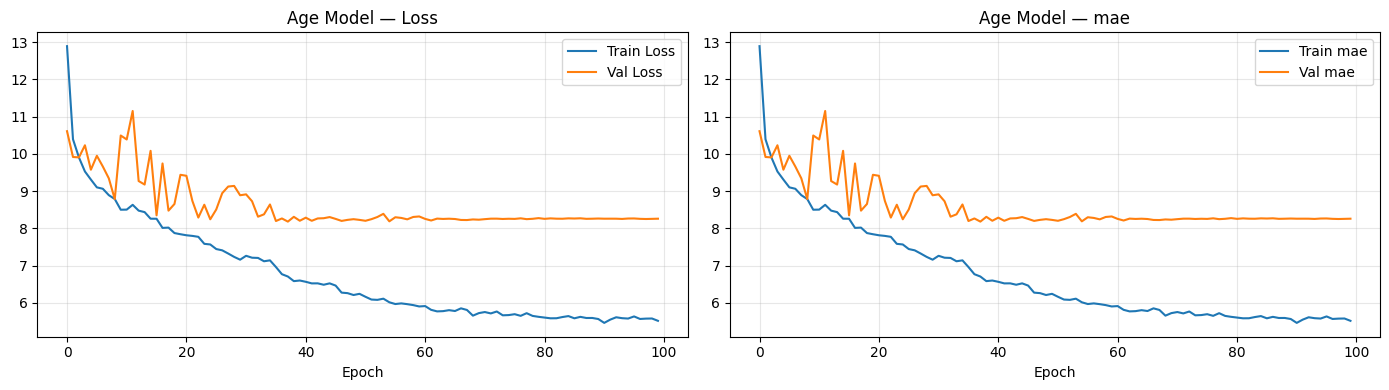

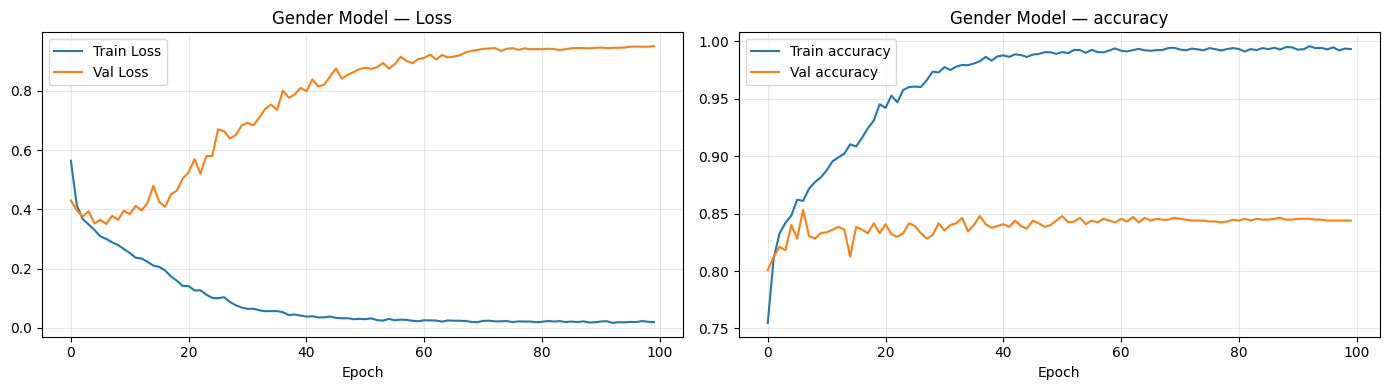

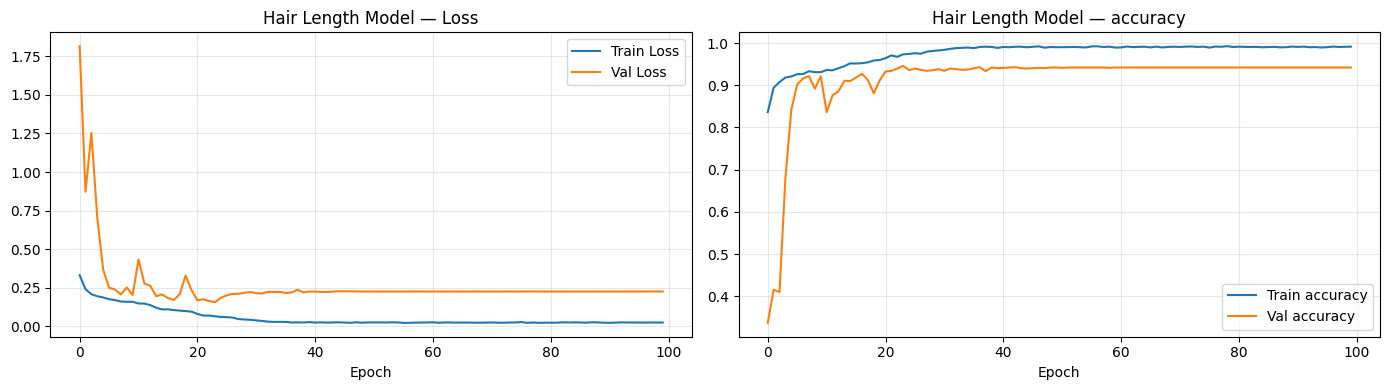

In [36]:
def plot_history(history, title, metric='accuracy'):
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    # Loss
    axes[0].plot(history.history['loss'], label='Train Loss')
    axes[0].plot(history.history['val_loss'], label='Val Loss')
    axes[0].set_title(f'{title} — Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Metric
    if metric in history.history:
        axes[1].plot(history.history[metric], label=f'Train {metric}')
        axes[1].plot(history.history[f'val_{metric}'], label=f'Val {metric}')
        axes[1].set_title(f'{title} — {metric}')
        axes[1].set_xlabel('Epoch')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_history(age_history, 'Age Model', metric='mae')
plot_history(gender_history, 'Gender Model', metric='accuracy')
plot_history(hair_history, 'Hair Length Model', metric='accuracy')

EVALUATION SUMMARY

📊 Age Estimation:
   MAE: 9.28 years
   Within 5 years: 40.5%


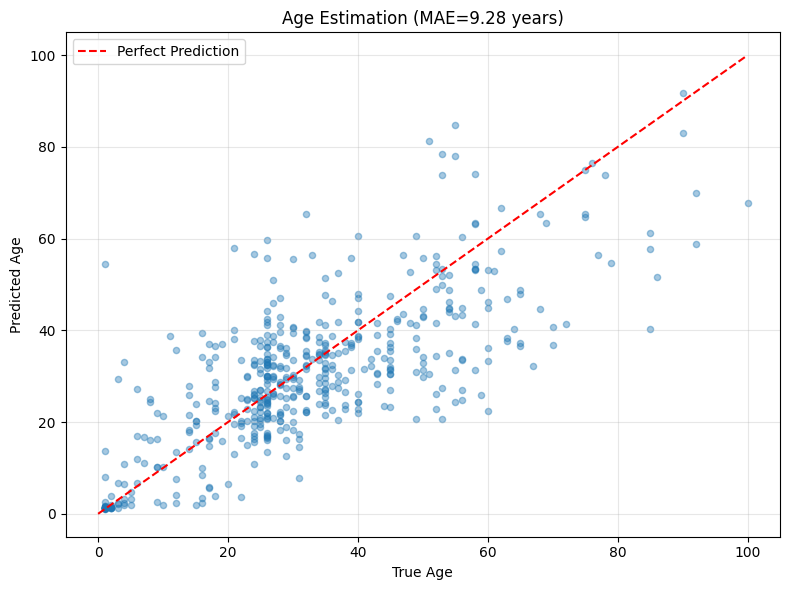


📊 Gender Classification:
              precision    recall  f1-score   support

        Male       0.84      0.83      0.84       780
      Female       0.82      0.83      0.83       720

    accuracy                           0.83      1500
   macro avg       0.83      0.83      0.83      1500
weighted avg       0.83      0.83      0.83      1500



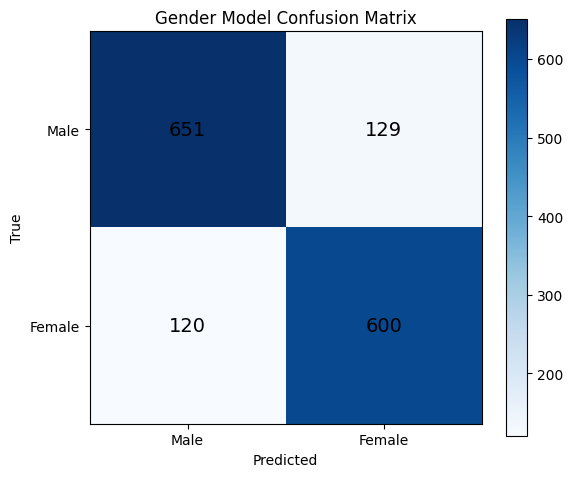


📊 Hair Length Classification:
              precision    recall  f1-score   support

  Short Hair       0.89      0.96      0.93       522
   Long Hair       0.98      0.94      0.96       978

    accuracy                           0.95      1500
   macro avg       0.93      0.95      0.94      1500
weighted avg       0.95      0.95      0.95      1500



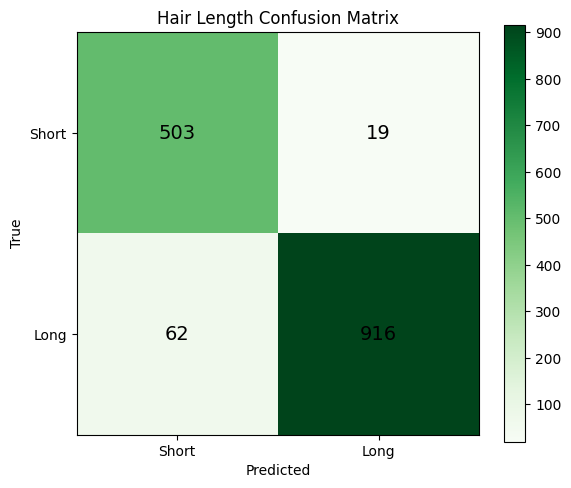

In [37]:
# ============================================================
# CELL 14: Model Evaluation & Metrics
# ============================================================

print("="*60)
print("EVALUATION SUMMARY")
print("="*60)

# --- Age Model ---
age_preds = age_model.predict(X_test, verbose=0).flatten()
age_preds_rounded = np.round(age_preds).astype(int)
age_true = y_age_test.astype(int)
age_mae_val = np.mean(np.abs(age_preds - y_age_test))
age_within_5 = np.mean(np.abs(age_preds - y_age_test) <= 5) * 100
print(f"\n Age Estimation:")
print(f"   MAE: {age_mae_val:.2f} years")
print(f"   Within 5 years: {age_within_5:.1f}%")

# Age prediction scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(age_true[:500], age_preds[:500], alpha=0.4, s=20)
plt.plot([0, 100], [0, 100], 'r--', label='Perfect Prediction')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.title(f'Age Estimation (MAE={age_mae_val:.2f} years)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Gender Model ---
gender_preds = np.argmax(gender_model.predict(X_test, verbose=0), axis=1)
gender_true = np.argmax(y_gender_test, axis=1)
print(f"\n Gender Classification:")
print(classification_report(gender_true, gender_preds, target_names=['Male', 'Female']))

# Confusion matrix
cm_gender = confusion_matrix(gender_true, gender_preds)
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm_gender, cmap='Blues')
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(['Male','Female']); ax.set_yticklabels(['Male','Female'])
for i in range(2):
    for j in range(2):
        ax.text(j, i, str(cm_gender[i,j]), ha='center', va='center', fontsize=14)
ax.set_title('Gender Model Confusion Matrix')
ax.set_xlabel('Predicted'); ax.set_ylabel('True')
plt.colorbar(im)
plt.tight_layout()
plt.show()

# --- Hair Model ---
hair_preds = np.argmax(hair_model.predict(X_test, verbose=0), axis=1)
hair_true = np.argmax(y_hair_test, axis=1)
print(f"\n Hair Length Classification:")
print(classification_report(hair_true, hair_preds, target_names=['Short Hair', 'Long Hair']))

cm_hair = confusion_matrix(hair_true, hair_preds)
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm_hair, cmap='Greens')
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(['Short','Long']); ax.set_yticklabels(['Short','Long'])
for i in range(2):
    for j in range(2):
        ax.text(j, i, str(cm_hair[i,j]), ha='center', va='center', fontsize=14)
ax.set_title('Hair Length Confusion Matrix')
ax.set_xlabel('Predicted'); ax.set_ylabel('True')
plt.colorbar(im)
plt.tight_layout()
plt.show()

In [38]:
# CELL 15: Core Prediction Logic

def preprocess_single(img_path):
    """Preprocess a single image for model inference."""
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Cannot read image: {img_path}")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE)).astype(np.float32) / 255.0
    return img_rgb, img_resized[np.newaxis, ...]  # (H,W,3) and (1,H,W,3)


def apply_business_logic(predicted_age, hair_pred, real_gender_pred):
    """
    Business Logic:
    - Age 20-30: Use HAIR LENGTH to determine gender label
        Long hair → "Female" (even if biologically male)
        Short hair → "Male" (even if biologically female)
    - Age < 20 or > 30: Use REAL GENDER prediction from gender model
    
    Returns: final_gender_label (str), reasoning (str)
    """
    is_target_age = AGE_MIN <= predicted_age <= AGE_MAX
    
    if is_target_age:
        if hair_pred == 1:  # Long hair
            final = "Female"
            reason = f"Age {predicted_age} (20–30) + Long Hair → Classified as Female"
        else:  # Short hair
            final = "Male"
            reason = f"Age {predicted_age} (20–30) + Short Hair → Classified as Male"
    else:
        final = real_gender_pred
        reason = f"Age {predicted_age} (outside 20–30) → Using real gender prediction: {real_gender_pred}"
    
    return final, reason, is_target_age


def full_predict(img_path):
    """
    Full prediction pipeline.
    Returns dict with all predictions and the final gender label.
    """
    img_rgb, img_tensor = preprocess_single(img_path)
    
    # 1. Predict Age
    predicted_age = float(age_model.predict(img_tensor, verbose=0)[0][0])
    predicted_age = max(1, min(100, round(predicted_age)))  # clip to valid range
    
    # 2. Predict Hair Length
    hair_probs = hair_model.predict(img_tensor, verbose=0)[0]
    hair_pred = int(np.argmax(hair_probs))
    hair_confidence = float(hair_probs[hair_pred]) * 100
    hair_label = "Long Hair" if hair_pred == 1 else "Short Hair"
    
    # 3. Predict Real Gender (used for age outside 20-30)
    gender_probs = gender_model.predict(img_tensor, verbose=0)[0]
    gender_pred = int(np.argmax(gender_probs))
    gender_confidence = float(gender_probs[gender_pred]) * 100
    real_gender_label = "Female" if gender_pred == 1 else "Male"
    
    # 4. Apply Business Logic
    final_gender, reasoning, in_target_age = apply_business_logic(
        predicted_age, hair_pred, real_gender_label
    )
    
    return {
        'image': img_rgb,
        'predicted_age': predicted_age,
        'in_target_age_range': in_target_age,
        'hair_label': hair_label,
        'hair_confidence': hair_confidence,
        'real_gender': real_gender_label,
        'gender_confidence': gender_confidence,
        'final_gender': final_gender,
        'reasoning': reasoning
    }

print(" Core prediction logic ready!")
print("Business rules:")
print("  Age 20–30 + Long Hair  → Female (regardless of real gender)")
print("  Age 20–30 + Short Hair → Male   (regardless of real gender)")
print("  Age < 20 or > 30       → Use real gender prediction")

 Core prediction logic ready!
Business rules:
  Age 20–30 + Long Hair  → Female (regardless of real gender)
  Age 20–30 + Short Hair → Male   (regardless of real gender)
  Age < 20 or > 30       → Use real gender prediction


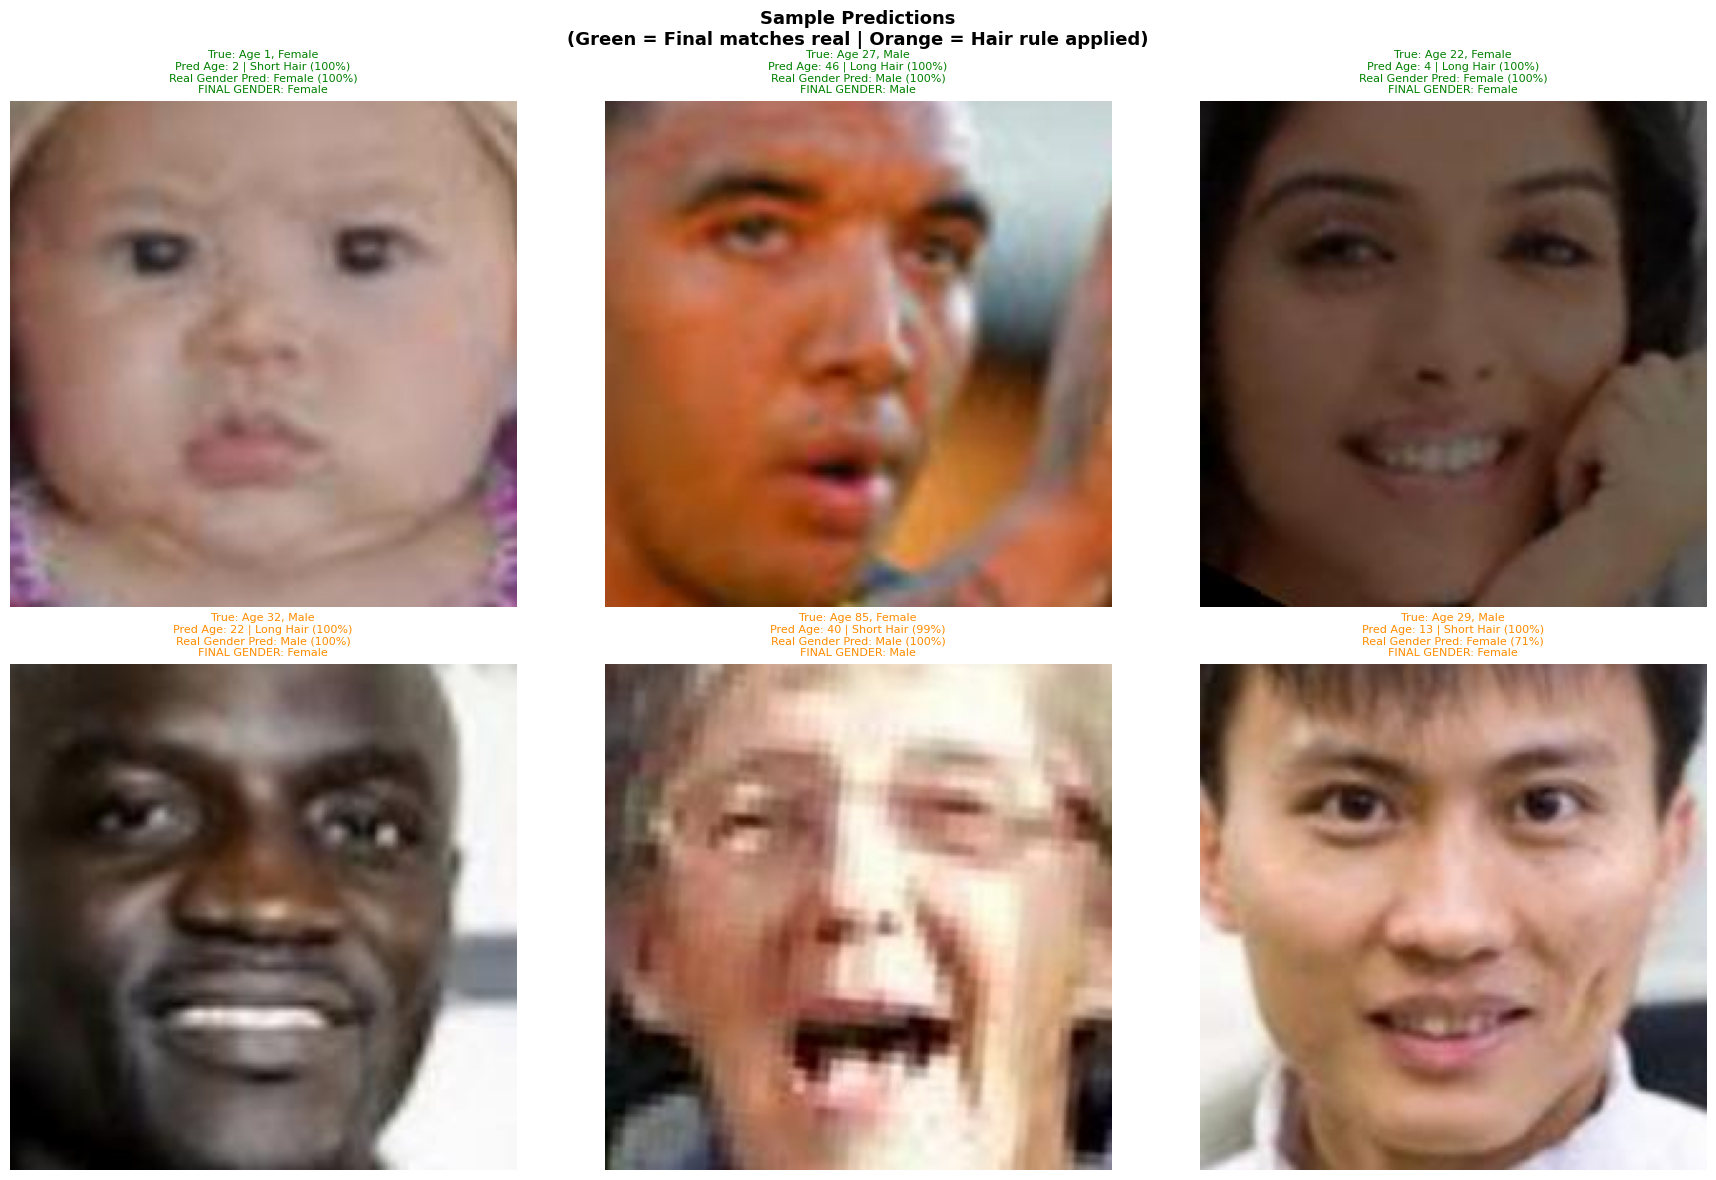

In [39]:
# CELL 16: Test Prediction Logic on Sample Images

# Test on 6 random samples from test set
test_paths = df.iloc[test_idx]['path'].values[:6]
test_ages = df.iloc[test_idx]['age'].values[:6]
test_genders = df.iloc[test_idx]['gender'].values[:6]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for ax, path, true_age, true_gender in zip(axes.flat, test_paths, test_ages, test_genders):
    result = full_predict(path)
    true_g = 'Female' if true_gender == 1 else 'Male'
    
    ax.imshow(result['image'])
    
    # Color-code: green if final matches real gender, orange if overridden by hair rule
    color = 'green' if result['final_gender'] == true_g else 'darkorange'
    
    ax.set_title(
        f"True: Age {true_age}, {true_g}\n"
        f"Pred Age: {result['predicted_age']} | {result['hair_label']} ({result['hair_confidence']:.0f}%)\n"
        f"Real Gender Pred: {result['real_gender']} ({result['gender_confidence']:.0f}%)\n"
        f"FINAL GENDER: {result['final_gender']}",
        color=color, fontsize=8
    )
    ax.axis('off')

plt.suptitle('Sample Predictions\n(Green = Final matches real | Orange = Hair rule applied)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

In [42]:
# CELL 17: Save All Models
import os
os.makedirs('/kaggle/working/models', exist_ok=True)

age_model.save('/kaggle/working/models/age_model.h5')
gender_model.save('/kaggle/working/models/gender_model.h5')
hair_model.save('/kaggle/working/models/hair_model.h5')

print("All models saved to /kaggle/working/models/")
for f in os.listdir('/kaggle/working/models/'):
    size_mb = os.path.getsize(f'/kaggle/working/models/{f}') / (1024**2)
    print(f"  {f}: {size_mb:.1f} MB")

All models saved to /kaggle/working/models/
  hair_model.h5: 7.9 MB
  age_model.h5: 24.8 MB
  best_age_model.keras: 25.0 MB
  gender_model.h5: 13.1 MB


In [47]:
# ============================================================
# CELL 18: Gradio GUI — Long Hair Gender Identification System
# ============================================================
import gradio as gr
import tempfile

# Uncomment below if loading models fresh after restart:
# age_model    = tf.keras.models.load_model('/kaggle/working/models/age_model.keras')
# gender_model = tf.keras.models.load_model('/kaggle/working/models/gender_model.keras')
# hair_model   = tf.keras.models.load_model('/kaggle/working/models/hair_model.keras')

def gradio_predict(image):
    with tempfile.NamedTemporaryFile(suffix='.jpg', delete=False) as tmp:
        image.save(tmp.name)
        tmp_path = tmp.name

    try:
        result = full_predict(tmp_path)
    except Exception as e:
        return f"Error: {str(e)}"
    finally:
        os.unlink(tmp_path)

    age_range_str = "(20-30 range, hair-based rule applies)" if result['in_target_age_range'] \
                    else "(outside 20-30, real gender used)"

    output = f"""{'='*50}
ANALYSIS RESULTS
{'='*50}

Predicted Age  : {result['predicted_age']} years
Age Range      : {age_range_str}

Hair Length    : {result['hair_label']}
Confidence     : {result['hair_confidence']:.1f}%

Real Gender    : {result['real_gender']}
Confidence     : {result['gender_confidence']:.1f}%

{'='*50}
FINAL PREDICTION : {result['final_gender'].upper()}
{'='*50}

Reasoning:
   {result['reasoning']}

Rule Applied:
   {'Hair-based gender rule (age 20-30)' if result['in_target_age_range']
     else 'Real gender model (age outside 20-30)'}
"""
    return output


with gr.Blocks(title="Long Hair Gender Identification System", theme=gr.themes.Soft()) as demo:

    gr.Markdown("""
    # Long Hair Gender Identification System

    ### How it works:
    | Age Range | Rule |
    |-----------|------|
    | **20-30** | Long hair → **Female**, Short hair → **Male** (regardless of real gender) |
    | **Outside 20-30** | Real gender predicted by CNN model |
    """)

    with gr.Row():
        with gr.Column(scale=1):
            img_input = gr.Image(
                type="pil",
                label="Upload Face Image",
                height=350
            )
            predict_btn = gr.Button("Analyze Image", variant="primary", size="lg")

        with gr.Column(scale=1):
            result_output = gr.Textbox(
                label="Prediction Results",
                lines=20,
                max_lines=25
            )

    predict_btn.click(
        fn=gradio_predict,
        inputs=img_input,
        outputs=result_output
    )

    gr.Markdown("""
    ---
    ### Model Details
    - **Age Model**: MobileNetV2 fine-tuned for regression on UTKFace
    - **Hair Model**: Custom 4-block CNN trained on heuristic-labeled UTKFace images
    - **Gender Model**: MobileNetV2 fine-tuned for binary classification
    - **Dataset**: UTKFace (real-world face images with age & gender labels)
    """)

demo.launch(share=True, debug=False)
print("Gradio GUI launched! Click the link above to open it.")

* Running on local URL:  http://127.0.0.1:7863
* Running on public URL: https://a1cb357dfbf8721f3a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Gradio GUI launched! Click the link above to open it.


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/httptools_impl.py", line 416, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1139, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 107, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/error

In [48]:
# CELL 19: Final Summary & Model Performance Report

print("="*60)
print("  LONG HAIR GENDER IDENTIFICATION — FINAL REPORT")
print("="*60)

print(f"""
 MODEL PERFORMANCE
┌─────────────────────────────────────────────┐
│ Age Estimation Model                        │
│   MAE (Mean Absolute Error): {age_mae_val:5.2f} years  │
│   Within ±5 years accuracy: {age_within_5:5.1f}%        │
├─────────────────────────────────────────────┤
│ Real Gender Classification Model            │
│   Test Accuracy: {gender_acc*100:5.2f}%                   │
├─────────────────────────────────────────────┤
│ Hair Length Classification Model            │
│   Test Accuracy: {hair_acc*100:5.2f}%                   │
└─────────────────────────────────────────────┘

🔧 ARCHITECTURE
  • Age Model:    MobileNetV2 + Custom head (regression)
  • Gender Model: MobileNetV2 + Custom head (binary classification)
  • Hair Model:   Custom 4-block CNN (binary classification)
  • Training Data: UTKFace dataset

 BUSINESS LOGIC
   Age 20–30 + Long Hair  → Predict: FEMALE
   Age 20–30 + Short Hair → Predict: MALE
   Age < 20 or > 30       → Predict: Real gender from CNN

  GUI
  • Built with Gradio (web-based)
  • Upload any face image for real-time prediction
  • Shows age, hair length, real gender, and final prediction
""")

  LONG HAIR GENDER IDENTIFICATION — FINAL REPORT

 MODEL PERFORMANCE
┌─────────────────────────────────────────────┐
│ Age Estimation Model                        │
│   MAE (Mean Absolute Error):  9.28 years  │
│   Within ±5 years accuracy:  40.5%        │
├─────────────────────────────────────────────┤
│ Real Gender Classification Model            │
│   Test Accuracy: 83.40%                   │
├─────────────────────────────────────────────┤
│ Hair Length Classification Model            │
│   Test Accuracy: 94.60%                   │
└─────────────────────────────────────────────┘

🔧 ARCHITECTURE
  • Age Model:    MobileNetV2 + Custom head (regression)
  • Gender Model: MobileNetV2 + Custom head (binary classification)
  • Hair Model:   Custom 4-block CNN (binary classification)
  • Training Data: UTKFace dataset

 BUSINESS LOGIC
   Age 20–30 + Long Hair  → Predict: FEMALE
   Age 20–30 + Short Hair → Predict: MALE
   Age < 20 or > 30       → Predict: Real gender from CNN

  GUI
  • Bu